# Never gonna give you up
# Never gonna DRAG you down

Howdy folks. Today we'll be quantum mechanic.

In [14]:
# First we set up some basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit as qis
import qiskit.pulse as qisp
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import IBMQ, schedule
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler.assembler import MeasLevel, MeasReturnType
from qiskit.tools.monitor import job_monitor

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')
backend_defaults = backend.defaults()
backend_properties = backend.properties()

In [15]:
scale_factor = 1e-7
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
            print('here')
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data


def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8) - (int(num + 8) % 16)

In [16]:
qubit = 0

GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

f01 = backend.configuration().hamiltonian['vars'][f'wq{qubit}']/(2*np.pi)
anhar = (backend.properties().qubits[qubit][3].value)*1e9 # anhar in Hz => convert to GHz
f12 = f01 + anhar
x_sigma = 80
x_duration = 320
x01_amp = 0.10218341976411754
x12_amp = 0.08218459717115828

# Discriminator

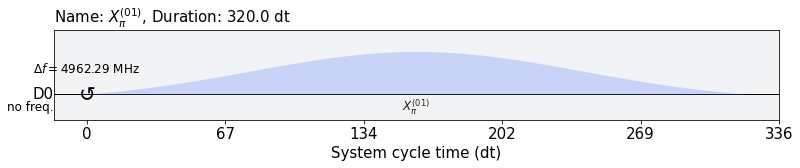

In [65]:
with qisp.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as inst_xpi01:
    drive_chan = qisp.drive_channel(qubit)
    qisp.set_frequency(f01, drive_chan)
    qisp.play(qisp.Gaussian(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            name=r'$X_{\pi}^{(01)}$'), drive_chan)
xpi01 = Gate('xp01', 1, [])
inst_xpi01.draw()

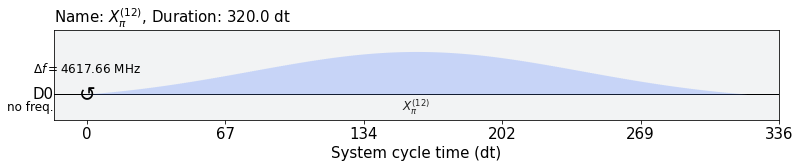

In [66]:
with qisp.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as inst_xpi12:
    drive_chan = qisp.drive_channel(qubit)
    qisp.set_frequency(f12, drive_chan)
    qisp.play(qisp.Gaussian(duration=x_duration,
                              amp=x12_amp,
                              sigma=x_sigma,
                              name=r'$X_{\pi}^{(12)}$'), drive_chan)

xpi12 = Gate('xp12', 1, [])
inst_xpi12.draw()

In [67]:
# 0 state
ground_circs = QuantumCircuit(1, 1)
ground_circs.measure(0, 0)

# 1 state
one_circs = QuantumCircuit(1, 1)
one_circs.append(xpi01, [0])
one_circs.measure(0, 0)
one_circs.add_calibration(xpi01, (0,), inst_xpi01, [])

# 2 state
two_circs = QuantumCircuit(1, 1)
two_circs.append(xpi01, [0])
two_circs.append(xpi12, [0])
two_circs.measure(0, 0)
two_circs.add_calibration(xpi12, (0,), inst_xpi12, [])
two_circs.add_calibration(xpi01, (0,), inst_xpi01, [])

In [ ]:
discriminator_job = backend.run([ground_circs, one_circs, two_circs],
                       meas_level=1,
                       meas_return='single',
                       shots=20000)

In [4]:
discriminator_data = get_job_data(discriminator_job, average=False)
zero_data = discriminator_data[0]
one_data = discriminator_data[1]
two_data = discriminator_data[2]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped


# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)
two_data_reshaped = reshape_complex_vec(two_data)

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape)  # verify IQ data shape

NUM_SHOTS = 20000

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)


def count(job, discriminator):
    data = get_job_data(job, average=False)
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result


KeyboardInterrupt



In [36]:
LDA_012

NameError: name 'LDA_012' is not defined

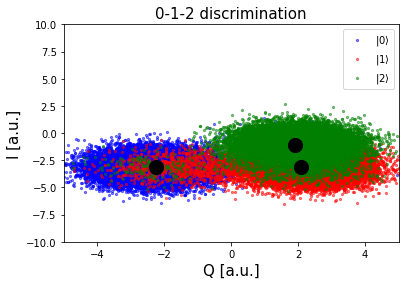

In [96]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=200, cmap='viridis', c='black',alpha=1.0)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

x_min = -5
x_max = 5
y_min = -10
y_max = 10
IQ_012_plot(x_min, x_max, y_min, y_max)

In [1]:
discr_data = count(discriminator_job, LDA_012)

NameError: name 'count' is not defined

In [ ]:
np.shape(discr_data)

In [ ]:
drag_exp_data = [[discr_data[i]['0'] / 20000, discr_data[i]['1'] / 20000, discr_data[i]['2'] / 20000] for i in
                   range(np.shape(discr_data)[0])]
drag_exp_data

# DRAG calibration

In [26]:
drive_betas = np.linspace(-20, 20, 33)
drive_beta = Parameter('drive_beta')
with qisp.build(backend=backend, default_alignment='sequential') as XX_sched:
    qisp.set_frequency(f12, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x12_amp,
                        sigma=x_sigma,
                        beta=drive_beta), qisp.drive_channel(0))
    qisp.shift_phase(-np.pi, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x12_amp,
                        sigma=x_sigma,
                        beta=drive_beta), qisp.drive_channel(0))
    qisp.shift_phase(-np.pi, qisp.drive_channel(0))

In [27]:
n = 3
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
qc_DRAG.x(0)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n3 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

In [28]:
n = 5
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
qc_DRAG.x(0)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n5 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

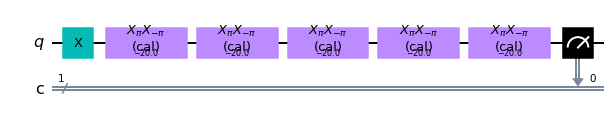

In [29]:
exp_DRAG_circuits_n5[0].draw(output='mpl')

In [30]:
n = 7
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
qc_DRAG.x(0)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n7 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

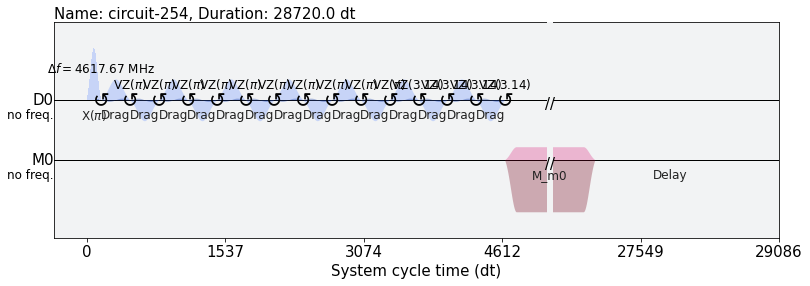

In [31]:
schedule(exp_DRAG_circuits_n7[7], backend).draw()

In [32]:
exp_DRAG_circuits = []
for i in exp_DRAG_circuits_n3:
    exp_DRAG_circuits.append(i)
for i in exp_DRAG_circuits_n5:
    exp_DRAG_circuits.append(i)
for i in exp_DRAG_circuits_n7:
    exp_DRAG_circuits.append(i)

In [33]:
len(exp_DRAG_circuits)

99

In [34]:
drag_job = backend.run(exp_DRAG_circuits,
                       meas_level=1,
                       meas_return='avg',
                       shots=20000)

In [35]:
print(drag_job.job_id())

6347df114a53e8b0bce39298


In [34]:
job_monitor(drag_job)

Job Status: job has successfully run


In [40]:
drag_job = backend.retrieve_job('6347df114a53e8b0bce39298')

In [41]:
drag_results = drag_job.result(timeout=120)
drag_values = []
for i in range(99):
    drag_values.append(drag_results.get_memory(i)[qubit] * 1e-7)
drag_values = np.real(drag_values)

In [42]:
drag_values

array([2.1357628, 2.136097 , 2.1336056, 2.136898 , 2.1462722, 2.1402348,
       2.142189 , 2.1630984, 2.152438 , 2.1456616, 2.1488208, 2.1457934,
       2.1579456, 2.1481638, 2.1623036, 2.160107 , 2.1469718, 2.1483702,
       2.1541792, 2.1419376, 2.162422 , 2.1540706, 2.1485888, 2.1566076,
       2.1467504, 2.1433264, 2.142853 , 2.151405 , 2.153055 , 2.1531396,
       2.1515896, 2.1504608, 2.1447072, 2.1014498, 2.0983224, 2.10679  ,
       2.1025278, 2.1157074, 2.1302038, 2.1253456, 2.1333368, 2.126429 ,
       2.1353934, 2.1278328, 2.1127044, 2.1298286, 2.1301706, 2.1210554,
       2.126594 , 2.1315234, 2.1448948, 2.1372312, 2.1378922, 2.1257444,
       2.116526 , 2.1252068, 2.1291902, 2.1435172, 2.129069 , 2.1320202,
       2.121975 , 2.1258684, 2.1191146, 2.1321236, 2.1238858, 2.1111158,
       2.0616262, 2.0576382, 2.0921722, 2.0579582, 2.0904134, 2.090748 ,
       2.089746 , 2.1050322, 2.0955382, 2.1100462, 2.1108484, 2.1128586,
       2.0900492, 2.0970466, 2.1018988, 2.1032588, 

In [45]:
drag_values_n3 = drag_values[0:33]
drag_values_n5 = drag_values[33:66]
drag_values_n7 = drag_values[66:99]

In [46]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit

In [105]:
def sinusoid(x, fit_params):
    A, B, drive_period, phi = fit_params
    return A*np.cos(2*np.pi*x/drive_period - phi) + B

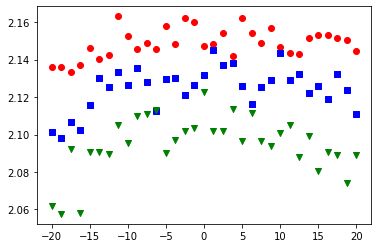

In [47]:
plt.scatter(drive_betas, drag_values_n3, marker='o', linestyle='-', color='red')
plt.scatter(drive_betas, drag_values_n5, marker='s', linestyle='-', color='blue')
plt.scatter(drive_betas, drag_values_n7, marker='v', linestyle='-', color='green')

In [106]:
fit_params_n3, y_fit_n3 = fit_function(drive_betas,
                                       drag_values_n3,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 40, 0])
fit_params_n5, y_fit_n5 = fit_function(drive_betas,
                                       drag_values_n5,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 20, 0])
fit_params_n7, y_fit_n7 = fit_function(drive_betas,
                                       drag_values_n7,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 20, 0])
x_val = np.linspace(-20, 20, 1000)
min_val = 1
x_optimum = 0
for x in x_val:
    l = (sinusoid(x, fit_params_n3) + np.abs(fit_params_n3[0]) - fit_params_n3[1])**2 + (sinusoid(x, fit_params_n5) + np.abs(fit_params_n5[0]) - fit_params_n5[1])**2 + (sinusoid(x, fit_params_n7) + np.abs(fit_params_n7[0]) - fit_params_n7[1])**2
    if l < min_val:
        min_val = l
        x_optimum = x

plt.scatter(drive_betas, drag_values_n3, marker='o', linestyle='-', color='red')
plt.plot(x_val, sinusoid(x_val, fit_params_n3), color = 'red')
plt.scatter(drive_betas, drag_values_n5, marker='s', linestyle='-', color='blue')
plt.plot(x_val, sinusoid(x_val, fit_params_n5), color = 'blue')
plt.scatter(drive_betas, drag_values_n7, marker='v', linestyle='-', color='green')
plt.plot(x_val, sinusoid(x_val, fit_params_n7), color = 'green')
plt.axvline(x_optimum, linestyle='--', color='yellow')
# plt.xlim(-2, 2)
x_optimum

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

In [11]:
x_optimum = -0.6206206206206204
beta_optimum = x_optimum

In [12]:
with qisp.build(backend=backend, default_alignment='sequential') as SX_sched:
    qisp.set_frequency(drive_freq, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x_amp/2,
                        sigma=x_sigma,
                        beta=beta_optimum), qisp.drive_channel(0))


In [13]:
SX_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_circs.append(qc_SX)

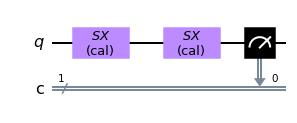

In [344]:
SX_circs[1].draw(output='mpl')

In [345]:
len(SX_circs)

100

In [346]:
SX_job = backend.run(SX_circs,
                    meas_level=2,
                    meas_return='single',
                    shots=2**14)
SX_job.job_id()

'633f8983e212b028d4beef0c'

In [117]:
job_monitor(SX_job)

Job Status: job is queued (156)

KeyboardInterrupt: 

# SX job
633ea125feb64c920ea00369: -1.3013013013013008
633f8983e212b028d4beef0c: -0.6206206206206204


In [14]:
SX_job = backend.retrieve_job('633f8983e212b028d4beef0c')

In [15]:
SX_results = SX_job.result().get_counts()

In [16]:
zero_population = [SX_results[i]['0']/2**14 for i in range(100)]
len(zero_population)

100

In [162]:
def SX_theory(val, epsilon):
    # return [1/2 + 1/2*np.cos(n*(np.pi/2 + epsilon)) for n in val]
    return [np.cos(n*(np.pi/2 + epsilon)/2)**2 for n in val]


[0.04397003]


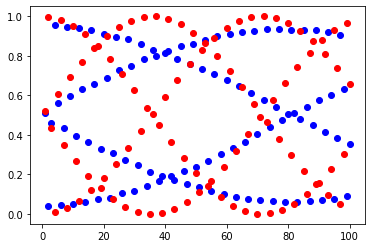

In [159]:
exp_num = [i + 1  for i in range(100)]

SX_params, SX_fit = fit_function(range(100),
                                       zero_population,
                                       SX_theory,
                                       [0.02])
print(SX_params)
plt.scatter(exp_num, zero_population, marker='o', linestyle='-', color='blue')
# plt.plot(range(100), SX_theory(range(100), SX_params), color='red')
# plt.xlim([0, 20])
plt.scatter(exp_num, SX_theory(exp_num, SX_params), color='red')

(0.0, 20.0)

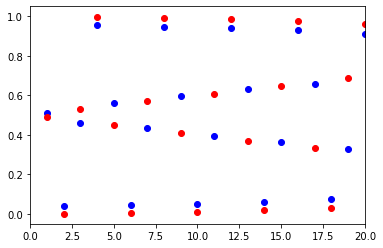

In [163]:
plt.scatter(exp_num, zero_population, marker='o', linestyle='-', color='blue')
plt.scatter(exp_num, SX_theory(exp_num, 0.02), color='red')
plt.xlim(0, 20)

In [18]:
SX_odd_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_odd_circs.append(qc_SX)


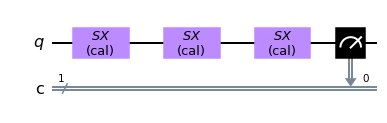

In [351]:
SX_odd_circs[1].draw(output='mpl')

In [266]:
SX_odd_job = backend.run(SX_odd_circs,
                     meas_level=2,
                     meas_return='single',
                     shots=2**14)
SX_odd_job.job_id()

'633ebe58338f42c077b76051'

In [19]:
SX_odd_job = backend.retrieve_job('633ebe58338f42c077b76051')

In [21]:
SX_odd_results = SX_odd_job.result().get_counts()
zero_population_odd = [SX_odd_results[i]['0']/2**14 for i in range(100)]

In [151]:
def SX_odd_theory(val, A, B, epsilon):
    # return [1/2 + 1/2*(-1)**n*np.cos(np.pi/2 + (2*n + 1)*epsilon) for n in val] #sheldon 2015
    return [A + B*np.cos((2*n + 1)*(epsilon + np.pi/2)) for n in val]
    # return [np.cos((epsilon + np.pi/2)*(n + 1/2))**2 for n in val]

In [166]:
num_fit = 78
exp_num = [i + 1  for i in range(100)]
SX_odd_params = curve_fit(SX_odd_theory, exp_num[:num_fit], zero_population_odd[:num_fit], p0 = [1/2, 1/2, 0.02], maxfev=5000)[0]
print(SX_odd_params)
residuals = [zero_population_odd[i] - SX_odd_theory(exp_num[i], *SX_odd_params) for i in range(num_fit)]
ss_res = np.sum(residuals**2)
ss_tot = np.sum((zero_population_odd[:num_fit]-np.mean(zero_population_odd[:num_fit]))**2)
r_squared = 1 - (ss_res / ss_tot)
print('r-squared =', r_squared)

plt.scatter(exp_num[:num_fit], zero_population_odd[:num_fit], marker='o', linestyle='-', color='blue')
# plt.plot(range(75), zero_population_odd[:75], marker='o', linestyle='-', color='blue')
# plt.xlim(0,10)

plt.scatter(exp_num[:num_fit], SX_odd_theory(range(num_fit), *SX_odd_params), color='red')

[0.50823087 0.4525394  0.02019534]


TypeError: 'int' object is not iterable

(0.0, 10.0)

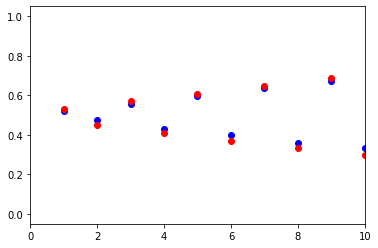

In [143]:
plt.scatter(exp_num[:75], zero_population_odd[:75], marker='o', linestyle='-', color='blue')
plt.scatter(exp_num[:75], SX_odd_theory(exp_num[:75], 0.02), color='red')
plt.xlim(0, 10)